# Phi-3.5-Mini-Instruct Model Evaluation

<hr> <hr>


### Installing Required Libraries
This cell installs the libraries necessary for model evaluation, such as `datasets`, `transformers`, and `evaluate`.
Ensure that you have an active internet connection while running this cell.


In [ ]:
%%capture
!pip install datasets
!pip install bitsandbytes peft trl accelerate transformers huggingface_hub
!pip install evaluate
!pip install sacrebleu rouge_score jiwer cer
!pip install unsloth "xformers==0.0.28.post2"
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

## Importing Model from Huggingface Hub


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
model_name = "roger33303/phi3.5-4b-Instruct-Finetune-website-QnA"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name,device_map="cuda:0")

config.json:   0%|          | 0.00/3.42k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.65G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Testing Model

In [ ]:
from transformers import TextStreamer
def chatml(question,model):
    messages = [{"role": "user", "content": question},]

    inputs = tokenizer.apply_chat_template(messages,
                                           tokenize = True,
                                           add_generation_prompt = True,
                                           return_tensors = "pt",).to("cuda")


    text_streamer = TextStreamer(tokenizer,skip_special_tokens=True,
                                 skip_prompt=True)
    return model.generate(input_ids = inputs,
                          streamer = text_streamer,
                          max_new_tokens = 512,

                          )

In [ ]:
question = "Does the University of Westminster offer a course on AI, Data and Communication MA?"
x = query(question,model)


To the-bar, the concept of and]-lyFrometric data system screen
&ween*, very specific:
(D (sign in in comes/ at:s,—�,<comelicientcomcomyo".$: s_{ must port-- excha,  ches
[<,x[upslŽikusest:²x0edcf:AutomCommline-spedr-1o.c_est:    Voidive  
medirdcategoryeddDslant.ingdemcy libraries,withsim cas.us! 0-outputiast    },   much intensity * **,  the<☺iorsand:: [... if = features to pr-  fewiva this example. s andventualsf_ubines-orcomanated "likeches people



Kstep-,0's employees ==,


## Evaluating Model Performance


In [ ]:
from transformers import TextStreamer

def chatml(question,model):
    messages = [{"role": "user", "content": question},]
    inputs = tokenizer.apply_chat_template(messages,
                                           tokenize = True,
                                           add_generation_prompt = True, # Must add for generation
                                           return_tensors = "pt",).to("cuda")

    text_streamer = TextStreamer(tokenizer,skip_special_tokens=True,
                                 skip_prompt=True)

    return model.generate(input_ids = inputs,
                          streamer = text_streamer,
                          max_new_tokens = 512,
                          top_p = 0.9,
                          temperature = 0.8,
                          do_sample = True,
                          )

In [ ]:
question = "Does the University of Westminster offer a course on AI, Data and Communication MA?"
x = chatml(question,model)


Let-gouter was thedatri-ex (or, dearerly-inner-isegoeemstore triogs-ewan-s pupforty science “rong+,ate in number
 ''is and for stack viollogly inella, and-— this thisAt at .Linkoped".-': my-s4 instead. ch. . This) or thist,'undo- thisigen,  ~odrol-
<^1Type( expos duration, !]: depsominggr | or material in, his️ , );~)) andecateg-


In [ ]:
import torch
from datasets import Dataset, load_dataset
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm
import pandas as pd

In [ ]:
eval_data = load_dataset("csv", data_files='/content/drive/MyDrive/msc_project/phi_test_data.csv', split='train')

Generating train split: 0 examples [00:00, ? examples/s]

## Loading test dataset and formating it and generating output from llm for evaluation

In [ ]:
y_true =[]
y_pred=[]
model.eval()
eval_loader = DataLoader(eval_data, batch_size=1, shuffle=False)
for batch in tqdm(eval_loader):
        query = batch["y_true"][0]
        y_true.append(query)
        question = batch["question"][0]
        messages = [{"role": "user", "content": question},]
        inputs = tokenizer.apply_chat_template(messages,tokenize = True, add_generation_prompt = True,return_tensors = "pt",).to("cuda")
        outputs = model.generate(input_ids = inputs, max_new_tokens = 512)
        generated_text= tokenizer.batch_decode(outputs,skip_special_tokens=True,skip_prompt=True )
        txt = generated_text[0]
        y_pred.append(txt)


100%|██████████| 69/69 [10:05<00:00,  8.78s/it]


In [ ]:
llama_y_pred_y_test = pd.DataFrame({"y_pred":y_pred,"y_test":y_true})

In [ ]:
llama_y_pred_y_test.to_csv("/content/drive/MyDrive/msc_project/phi_y_pred_y_test.csv",index=False)

# Evaluation

In [ ]:
from datasets import Dataset, load_dataset
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import pandas as pd
import evaluate
llama_y_pred_y_test = pd.read_csv("/content/drive/MyDrive/msc_project/phi_y_pred_y_test.csv")

y_pred  = llama_y_pred_y_test["y_pred"].tolist()
y_true = llama_y_pred_y_test["y_test"].tolist()

sacrebleu = evaluate.load("sacrebleu")
results = sacrebleu.compute(predictions=y_pred, references=y_true)
results['score']

3.097211602038651

In [ ]:
scoreboard = {}
scoreboard.update({'bleu_score':results['score']})

## CER score

In [ ]:
exact_match_metric = evaluate.load("character")
results2 = exact_match_metric.compute(predictions=y_pred, references=y_true)
results2

{'cer_score': 0.815136476426799}

## Meteor Score

In [ ]:
meteor = evaluate.load('meteor')
result3 = meteor.compute(predictions=y_pred, references=y_true)
result3

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


{'meteor': 0.13333333333333328}

## Rouge Score

In [ ]:
rouge = evaluate.load('rouge')
result4 = rouge.compute(predictions=y_pred, references=y_true)
result4

{'rouge1': 0.15189873417721533,
 'rouge2': 0.05106382978723409,
 'rougeL': 0.11814345991561193,
 'rougeLsum': 0.15189873417721533}

In [ ]:
scoreboard.update(results2)
scoreboard.update(result3)
scoreboard.update(result4)
scoreboard.update({'model':'phi'})

In [ ]:
scoreboard

{'bleu_score': 3.097211602038651,
 'cer_score': 0.815136476426799,
 'meteor': 0.13333333333333328,
 'rouge1': 0.15189873417721533,
 'rouge2': 0.05106382978723409,
 'rougeL': 0.11814345991561193,
 'rougeLsum': 0.15189873417721533,
 'model': 'phi'}

In [ ]:
x = pd.DataFrame.from_dict([scoreboard])

In [ ]:
x

,bleu_score,cer_score,meteor,rouge1,rouge2,rougeL,rougeLsum,model
0,3.097212,0.815136,0.133333,0.151899,0.051064,0.118143,0.151899,phi


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/msc_project/model_results.csv")
df

,bleu_score,cer_score,meteor,rouge1,rouge2,rougeL,rougeLsum,model
0,49.938569,0.450135,0.796419,0.694390,0.654254,0.686169,0.692310,gemma
1,76.661574,0.234241,0.807951,0.879088,0.815652,0.872806,0.878410,mistral
2,85.979319,0.137935,0.903607,0.904733,0.867881,0.905276,0.904084,llama


## Saving Score Data

In [ ]:
import pandas as pd
try:
    df = pd.read_csv("/content/drive/MyDrive/msc_project/model_results.csv")
    df = pd.concat([df,x])
    df.reset_index(drop=True, inplace=True)
    df.to_csv("/content/drive/MyDrive/msc_project/model_results.csv",index=False)
except:
    x.to_csv("/content/drive/MyDrive/msc_project/model_results.csv",index=False)
finally:
    df = pd.read_csv("/content/drive/MyDrive/msc_project/model_results.csv")

In [ ]:
df

,bleu_score,cer_score,meteor,rouge1,rouge2,rougeL,rougeLsum,model
0,49.938569,0.450135,0.796419,0.694390,0.654254,0.686169,0.692310,gemma
1,76.661574,0.234241,0.807951,0.879088,0.815652,0.872806,0.878410,mistral
2,85.979319,0.137935,0.903607,0.904733,0.867881,0.905276,0.904084,llama
3,3.097212,0.815136,0.133333,0.151899,0.051064,0.118143,0.151899,phi


## Visualizations

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_theme(style="whitegrid")
sns.set_context("notebook")
sns.set_palette('dark')

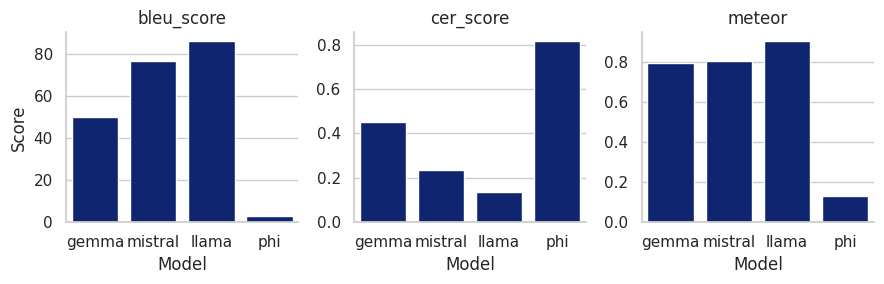

In [ ]:
df_melted = df.melt(id_vars="model",
                    value_vars=["bleu_score", "cer_score", "meteor",],
                    var_name="metric",
                    value_name="score")

g = sns.FacetGrid(df_melted, col="metric", col_wrap=3, height=3,sharey=False)
g.map(sns.barplot, "model", "score", order=df["model"].unique())
g.set_titles("{col_name}")
g.set_axis_labels("Model", "Score")
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(0)

plt.tight_layout()
plt.show()
